<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и обзор данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Обзор данных</a></span></li></ul></li><li><span><a href="#Подготовка-данных-для-TF-IDF" data-toc-modified-id="Подготовка-данных-для-TF-IDF-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных для TF-IDF</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-к-кросс-валидации" data-toc-modified-id="Подготовка-к-кросс-валидации-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка к кросс-валидации</a></span></li><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель LightGBM</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект для "Викишоп"

**Описание проекта:** Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Данные:** В распоряжении набор данных с разметкой о токсичности правок.

**Цель:** Обучить модель классифицировать комментарии на позитивные и негативные. 

## Загрузка и обзор данных

### Импорт библиотек

In [ ]:
!python -m spacy download en_core_web_sm

In [14]:
import textwrap
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import spacy
from tqdm import notebook
import nltk 
from nltk.corpus import stopwords as nltk_stopwords
from wordcloud import WordCloud
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Загрузка данных

In [15]:
comments = pd.read_csv('12_toxic_comments.csv', index_col=0)

### Обзор данных

In [16]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [17]:
display(comments.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [18]:
display(comments.describe(include='all'))

,text,toxic
count,159292,159292.000000
unique,159292,NaN
top,Explanation\nWhy the edits made under my usern...,NaN
freq,1,NaN
mean,NaN,0.101612
std,NaN,0.302139
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


In [19]:
print('Количество пустых строк в данных:', comments.loc[comments['text'].isna(), 'toxic'].count())

Количество пустых строк в данных: 0


In [20]:
print('Количество дубликатов в данных:',comments.loc[comments.duplicated(), 'toxic'].count())

Количество дубликатов в данных: 0


In [21]:
comments_analysis = comments.groupby('toxic')['text'].agg('count')
display(comments_analysis.reset_index())

,toxic,text
0,0,143106
1,1,16186


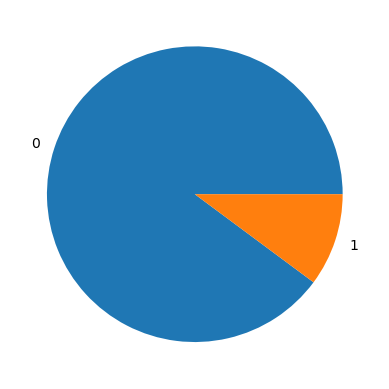

In [22]:
plt.pie(comments_analysis, labels=comments_analysis.index);

In [23]:
#Очистка текста комментариев от всех символов, кроме английского языка и пробелов. Плюс удаление двойных пробелов
def only_english_symbols(text):
    return re.sub('\s\s+', ' ', re.sub(r'[^a-zA-Z ]', ' ', text))

In [24]:
comments['text'] = comments['text'].apply(only_english_symbols)

In [25]:
display('Всего пустых строк после очистки символов:', comments.loc[comments['text']==' ', 'text'].count())

'Всего пустых строк после очистки символов:'

11

In [26]:
#Удалим пустые строки
comments = comments[comments['text']!=' ']

In [27]:
#Обрезка строк
#Spacy не может обработать строки с более чем 512 символами. Поэтому обрежем строки
def text_shorten(text):
    new_text = text
    if len(text)>512:
        new_text = textwrap.shorten(text=text, width=512, placeholder='')
    return new_text

In [28]:
comments['text'] = comments['text'].apply(text_shorten)

In [29]:
display(comments.head())

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0


**Вывод:**

* В целях построения модели загружен датасет из 159292 уникальных комментариев с разметкой о токсичности правок;
* Всего в датасете содержится 10% токсичных комментариев;
* В датасете были обнаружены комментарии не на английском. Ввиду того, что основной язык для модели - английский, то с помощью регулярного выражения в тексте комментариев были удалены все символы, не являющиеся буквами английского алфавита, точками или пробелами. После корректировки текста комментариев было удалено 11 пустых строк;
* Так как Spacy не обрабатывают строки длиной более чем 512 символов, строки были обрезаны до максимальной длины (512).

## Подготовка данных для TF-IDF

In [30]:
#Создание корпуса
corpus = comments['text'].copy()

In [31]:
nlp = spacy.load("en_core_web_sm")

In [32]:
#Функция лемматизации
def lemmatize(text):
    from tqdm.notebook import tqdm
    tqdm.pandas()
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc]).lower()

In [33]:
%%time
#Лемматизация
from tqdm.notebook import tqdm
tqdm.pandas()
corpus = corpus.progress_apply(lemmatize)
print(corpus)

  0%|          | 0/159281 [00:00<?, ?it/s]

0         explanation why the edit make under my usernam...
1         d aww he match this background colour i m seem...
2         hey man i m really not try to edit war it s ju...
3         more i can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159446      and for the second time of ask when your vie...
159447    you should be ashamed of yourself that be a ho...
159448    spitzer umm there s no actual article for pros...
159449    and it look like it be actually you who put on...
159450      and i really don t think you understand i co...
Name: text, Length: 159281, dtype: object
Wall time: 36min 41s


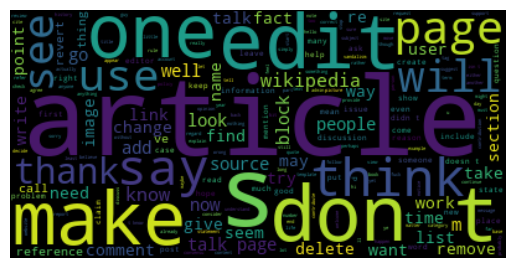

In [34]:
#Облако слов
word_c = WordCloud().generate(" ".join(corpus.values))
plt.imshow(word_c, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
#Разделение данных на выборки
features_train_tf_idf, features_test_tf_idf, target_train_tf_idf, target_test_tf_idf = train_test_split(corpus, 
    comments['toxic'], test_size=0.2, random_state=12345, stratify=comments['toxic'])
for i in [features_train_tf_idf, features_test_tf_idf, target_train_tf_idf, target_test_tf_idf]:
    display(i.shape)

print(f"Количество строк в train по классам: {np.bincount(target_train_tf_idf)}")
print(f"Количество строк в test по классам: {np.bincount(target_test_tf_idf)}")

(127424,)

(31857,)

(127424,)

(31857,)

Количество строк в train по классам: [114476  12948]
Количество строк в test по классам: [28620  3237]


## Обучение моделей

### Подготовка к кросс-валидации

In [45]:
def f1_metric(target, pred):
    return f1_score(target, pred)

my_scorer = make_scorer(f1_metric, greater_is_better=True)

In [46]:
#Загрузка стоп-слов
nltk.download('stopwords')
stopwords = list(set(nltk_stopwords.words('english')))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KyxC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Модель логистической регрессии

In [47]:
%%time
print('Модель логистической регрессии на TF-IDF:')

grid_param = {'vect__stop_words':[stopwords],
              'vect__ngram_range':[(1, 1), (2, 2)], 
              'vect__max_features':[3000], 
              'vect__dtype':[np.float32],
              'model__random_state':[12345],
              'model__C':np.linspace(0.1, 1, num=10),
              'model__penalty':['l2', 'none'],
              'model__max_iter':[1000]
             }
pipeline = Pipeline([("vect", TfidfVectorizer()),
                     ("model", LogisticRegression())])

grid_logic_model_tf_idf = GridSearchCV(estimator=pipeline, param_grid=grid_param, n_jobs=-1, cv=5, scoring=my_scorer)
grid_logic_model_tf_idf.fit(features_train_tf_idf, target_train_tf_idf)
best_logic_model_tf_idf = grid_logic_model_tf_idf.best_estimator_
print('Параметры лучшей модели, обученной на TF-IDF:', grid_logic_model_tf_idf.best_params_)
print('F1 модели, обученной на TF-IDF:', grid_logic_model_tf_idf.best_score_)

Модель логистической регрессии на TF-IDF:


C:\Users\KyxC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Параметры лучшей модели, обученной на TF-IDF: {'model__C': 0.1, 'model__max_iter': 1000, 'model__penalty': 'none', 'model__random_state': 12345, 'vect__dtype': <class 'numpy.float32'>, 'vect__max_features': 3000, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['again', 'will', 'before', 'which', 'them', 'then', 'shouldn', 'were', 'an', 'more', 'there', 'he', 'own', 'over', 'and', 'do', 'herself', 'll', 'how', "should've", 'or', 'why', 'am', 'themselves', 'doing', 'wouldn', 'by', "you've", 'very', 'its', "hasn't", 'those', 'a', 'me', 'against', 've', 'hers', 'doesn', 'not', 't', 'my', 'being', 'she', "aren't", "won't", 'only', 'hadn', 'did', 'needn', "doesn't", 'any', 'each', 'couldn', 'this', "that'll", "haven't", 'y', "wouldn't", "shouldn't", 'than', 'under', 'up', 'we', "didn't", 'few', 'you', "needn't", 'while', 'out', 'myself', 'weren', 'd', 'yourselves', 'theirs', 'i', 'other', 'these', 'because', 'been', 'such', 'just', 'from', 'o', "mightn't", 'having', 'can', 'all', 'your', '

C:\Users\KyxC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Модель случайного леса

In [49]:
%%time
print('Модель случайного леса на TF-IDF:')

grid_param = {'vect__stop_words':[stopwords],
              'vect__ngram_range':[(1, 1), (2, 2)], 
              'vect__max_features':[7000], 
              'vect__dtype':[np.float32],
              'model__random_state':[12345],
              'model__n_estimators':range(100, 201, 100),
              'model__max_depth':[15]
             }
pipeline = Pipeline([("vect", TfidfVectorizer()),
                     ("model", RandomForestClassifier())])    

grid_forest_model_tf_idf = GridSearchCV(estimator=pipeline, param_grid=grid_param, n_jobs=-1, cv=5, scoring=my_scorer)
grid_forest_model_tf_idf.fit(features_train_tf_idf, target_train_tf_idf)
best_forest_model_tf_idf = grid_forest_model_tf_idf.best_estimator_
print('Параметры лучшей модели, обученной на TF-IDF:', grid_forest_model_tf_idf.best_params_)
print('F1 модели, обученной на TF-IDF:', grid_forest_model_tf_idf.best_score_)

Модель случайного леса на TF-IDF:
Параметры лучшей модели, обученной на TF-IDF: {'model__max_depth': 15, 'model__n_estimators': 100, 'model__random_state': 12345, 'vect__dtype': <class 'numpy.float32'>, 'vect__max_features': 7000, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['again', 'will', 'before', 'which', 'them', 'then', 'shouldn', 'were', 'an', 'more', 'there', 'he', 'own', 'over', 'and', 'do', 'herself', 'll', 'how', "should've", 'or', 'why', 'am', 'themselves', 'doing', 'wouldn', 'by', "you've", 'very', 'its', "hasn't", 'those', 'a', 'me', 'against', 've', 'hers', 'doesn', 'not', 't', 'my', 'being', 'she', "aren't", "won't", 'only', 'hadn', 'did', 'needn', "doesn't", 'any', 'each', 'couldn', 'this', "that'll", "haven't", 'y', "wouldn't", "shouldn't", 'than', 'under', 'up', 'we', "didn't", 'few', 'you', "needn't", 'while', 'out', 'myself', 'weren', 'd', 'yourselves', 'theirs', 'i', 'other', 'these', 'because', 'been', 'such', 'just', 'from', 'o', "mightn't", 'having', 'can'

### Модель LightGBM

In [51]:
%%time
print('Модель LightGBM на TF-IDF:')

grid_param = {'vect__stop_words':[stopwords],
              'vect__ngram_range':[(1, 1), (2, 2)], 
              'vect__max_features':[7000], 
              'vect__dtype':[np.float32],
              'model__n_estimators':range(100, 201, 100),
              'model__max_depth':[15],
              'model__num_threads': [-1],
              'model__random_state':[12345],
              'model__eval_metric':['f1']
             }
pipeline = Pipeline([("vect", TfidfVectorizer()),
                     ("model", LGBMClassifier())])    

grid_lightgbm_model_tf_idf = GridSearchCV(estimator=pipeline, param_grid=grid_param, n_jobs=-1, cv=5, scoring=my_scorer)
grid_lightgbm_model_tf_idf.fit(features_train_tf_idf, target_train_tf_idf, model__eval_metric='f1')
best_lightgbm_model_tf_idf = grid_lightgbm_model_tf_idf.best_estimator_
print('Параметры лучшей модели, обученной на TF-IDF:', grid_lightgbm_model_tf_idf.best_params_)
print('F1 модели, обученной на TF-IDF:', grid_lightgbm_model_tf_idf.best_score_)

Модель LightGBM на TF-IDF:
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
Параметры лучшей модели, обученной на TF-IDF: {'model__eval_metric': 'f1', 'model__max_depth': 15, 'model__n_estimators': 200, 'model__num_threads': -1, 'model__random_state': 12345, 'vect__dtype': <class 'numpy.float32'>, 'vect__max_features': 7000, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['again', 'will', 'before', 'which', 'them', 'then', 'shouldn', 'were', 'an', 'more', 'there', 'he', 'own', 'over', 'and', 'do', 'herself', 'll', 'how', "should've", 'or', 'why', 'am', 'themselves', 'doing', 'wouldn', 'by', "you've", 'very', 'its', "hasn't", 'those', 'a', 'me', 'against', 've', 'hers', 'doesn', 'not', 't', 'my', 'being', 'she', "aren't", "won't", 'only', 'hadn', 'did', 'needn', "doesn't", 'any', 'each', 'couldn', 'this', "that'll", "haven't", 'y', "wouldn't", "shouldn't", 'than', 'under', 'up', 'we

### Модель CatBoost

In [53]:
%%time
print('Модель CatBoost на TF-IDF:')

grid_param = {'vect__ngram_range':[(1, 1), (2, 2)]}
pipeline = Pipeline([("vect", TfidfVectorizer(stop_words=stopwords, max_features=3000, dtype=np.float32)),
                     ("model", CatBoostClassifier(iterations=50, max_depth=10, loss_function='Logloss', 
                                                  eval_metric='TotalF1', verbose=300, random_state=12345))
                    ])

grid_catboost_model_tf_idf = GridSearchCV(estimator=pipeline, param_grid=grid_param, n_jobs=-1, cv=5, scoring=my_scorer)
grid_catboost_model_tf_idf.fit(features_train_tf_idf, target_train_tf_idf)
best_catboost_model_tf_idf = grid_catboost_model_tf_idf.best_estimator_
print('Параметры лучшей модели, обученной на TF-IDF:', grid_catboost_model_tf_idf.best_params_)
print('F1 модели, обученной на TF-IDF:', grid_catboost_model_tf_idf.best_score_)

Модель CatBoost на TF-IDF:
Learning rate set to 0.5
0:	learn: 0.9101352	total: 5.46s	remaining: 4m 27s
49:	learn: 0.9564859	total: 4m 40s	remaining: 0us
Параметры лучшей модели, обученной на TF-IDF: {'vect__ngram_range': (1, 1)}
F1 модели, обученной на TF-IDF: 0.7335949710047052
Wall time: 32min 40s


**Вывод:**

По результатам обучения модели на данных TF-IDF получены следующие метрики F1:
* Модель логистической регрессии: 0.7544, при параметрах лучшей модели:{'model__C': 0.1, 'model__penalty': 'none', 'vect__ngram_range': (1, 1),}
* Модель случайного леса: 0.0792, при параметрах лучшей модели:{'model__max_depth': 15, 'model__n_estimators': 100, 'vect__ngram_range': (1, 1)}
* Модель LightGBM: 0.7431, при параметрах лучшей модели:{'model__max_depth': 15, 'model__n_estimators': 200, 'vect__ngram_range': (1, 1)}
* Модель Catboost: 0.7335, при параметрах лучшей модели:{'vect__ngram_range': (1, 1)}

Таким образом, по результатам тестирования лучшее F1 показала модель логистической регрессии

## Тестирование лучшей модели

In [55]:
best_model = best_logic_model_tf_idf
pred_test = best_model.predict(features_test_tf_idf)
print('F1 лучшей модели после тестирования:', f1_metric(target_test_tf_idf.values, pred_test))

F1 лучшей модели после тестирования: 0.7566455153489968


**Вывод:**

По результатам тестирования модели получено значение F1=0.7566

## Общий вывод

**1. Вывод по результатам обзора данных**

В целях построения модели загружен датасет из 159292 уникальных комментариев с разметкой о токсичности правок. В датасете были обнаружены комментарии не на английском, поэтому была произведена корректировка текста комментариев. После корректировки было удалено 11 пустых строк. Всего в датасете содержится 10% токсичных комментариев.


**2. Результат обработки данных**

Проведена додготовка данных для обучения моделей на величинах TF-IDF


**3. Результат обучения моделей**

По результатам обучения модели на данных TF-IDF получены следующие метрики F1:
* Модель логистической регрессии: 0.7544, при параметрах лучшей модели:{'model__C': 0.1, 'model__penalty': 'none', 'vect__ngram_range': (1, 1),}
* Модель случайного леса: 0.0792, при параметрах лучшей модели:{'model__max_depth': 15, 'model__n_estimators': 100, 'vect__ngram_range': (1, 1)}
* Модель LightGBM: 0.7431, при параметрах лучшей модели:{'model__max_depth': 15, 'model__n_estimators': 200, 'vect__ngram_range': (1, 1)}
* Модель Catboost: 0.7335, при параметрах лучшей модели:{'vect__ngram_range': (1, 1)}

Таким образом, по результатам тестирования лучшее F1 показала модель логистической регрессии


**4. Результат тестирования лучшей модели**

По результатам тестирования модели получено значение F1=0.7566